In [10]:
import numpy as np #scientific computing
import pandas as pd #data management
import itertools

#matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick #for percentage ticks

#Imbalancing
from imblearn.over_sampling import SMOTE

#Imputer
from sklearn.impute import SimpleImputer

#sklearn for modeling
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier #Decision Tree algorithm
from sklearn.model_selection import train_test_split #Data split function
from sklearn.preprocessing import LabelEncoder #OneHotEncoding
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score



#Decision tree plot
import pydotplus
import seaborn as sns
from IPython.display import Image

#Models
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Loading the datasets

In [11]:
data = pd.read_csv("./twitter_sentiments.csv")

In [12]:
data.head()

stamp coin  positive_posts  negative_posts  \
0  2021-04-05 11:00:00.000000  BTC              11               5   
1  2021-04-05 12:00:00.000000  BTC              68              16   
2  2021-04-05 13:00:00.000000  BTC              39               9   
3  2021-04-05 14:00:00.000000  BTC              67              10   
4  2021-04-05 15:00:00.000000  BTC              53               8   

   avg_followers  class  
0    2560.418605      1  
1    2910.931818      1  
2    1445.543011      1  
3    4237.107143      1  
4    2576.864706      0

In [13]:
# drop first column because its sudo primary key
data = data.iloc[1:,2:]
data.head(10).style

In [14]:
data.describe().T

count         mean          std         min          25%  \
positive_posts  440.0    46.059091    16.489278    0.000000    35.000000   
negative_posts  440.0    10.368182     6.731823    0.000000     6.000000   
avg_followers   440.0  4216.291821  2626.432267  707.122807  2594.797045   
class           440.0     0.479545     0.500150    0.000000     0.000000   

                      50%          75%           max  
positive_posts    43.5000    54.250000    134.000000  
negative_posts     9.0000    12.000000     57.000000  
avg_followers   3499.0209  4871.468539  23445.186603  
class              0.0000     1.000000      1.000000

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 1 to 440
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   positive_posts  440 non-null    int64  
 1   negative_posts  440 non-null    int64  
 2   avg_followers   440 non-null    float64
 3   class           440 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 13.9 KB


# Data Visualization

/opt/anaconda3/envs/masterthesis/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


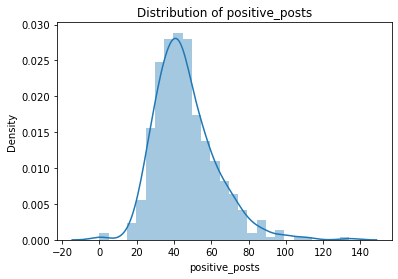

/opt/anaconda3/envs/masterthesis/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


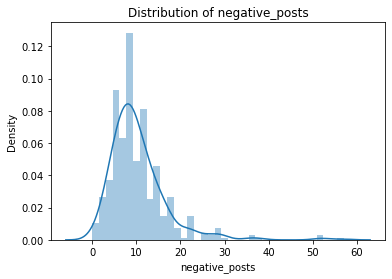

In [16]:
numeric_cols_to_distribute = ['positive_posts','negative_posts']
for col in data[numeric_cols_to_distribute]:
    plt.title(f'Distribution of {col}')
    sns.distplot(data[col])
    plt.show()

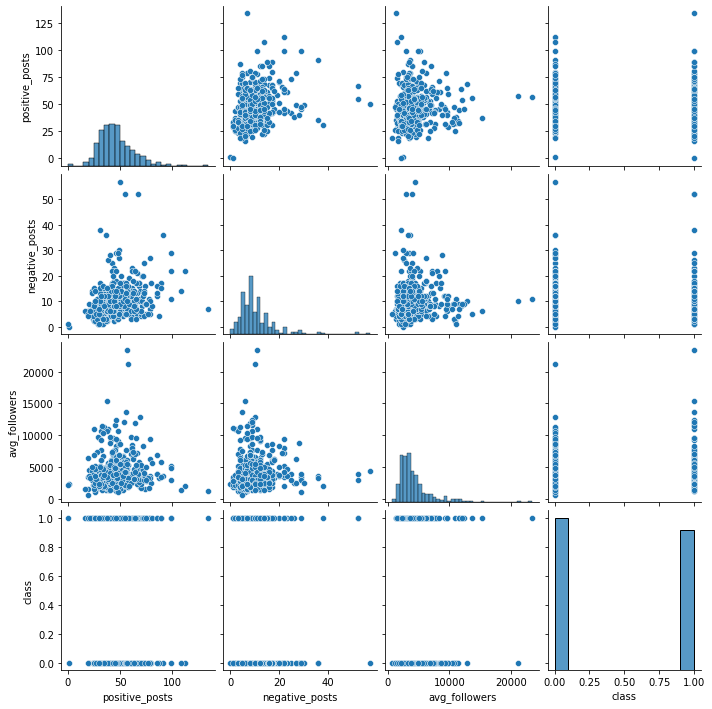

In [17]:
sns.pairplot(data)
plt.show()

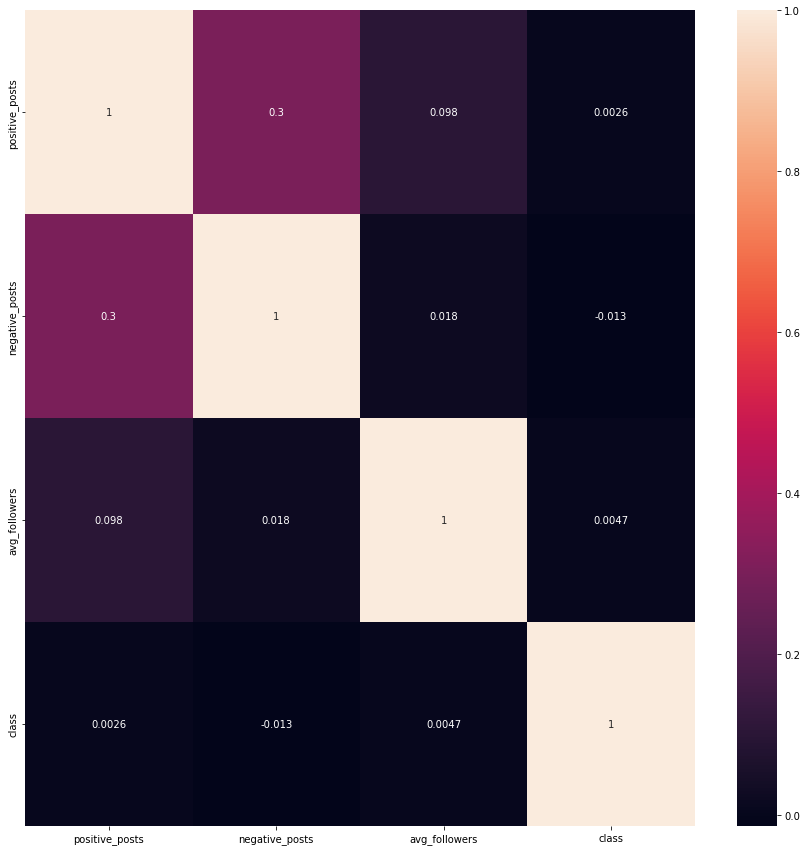

In [18]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), annot = True)
plt.show()

# Preprocessing Data

In [19]:
train, target = data.loc[:, data.columns != 'class'], data['class'] #define feature matrix X and labels y
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.3, random_state = 12345) #split data 70:30

In [20]:
X_train

positive_posts  negative_posts  avg_followers
113              58              11    5423.111111
133              19               5     707.122807
17               34               5    1971.543860
68               46              29    3480.814208
138              39               7    5281.394366
..              ...             ...            ...
383              85              12    3970.000000
426              40               6    4070.946524
421              35               8    2069.207407
130              34               3    3984.379310
286              67              52    3954.675585

[308 rows x 3 columns]

In [21]:
y_train

113    1
133    0
17     1
68     0
138    1
      ..
383    1
426    0
421    0
130    1
286    1
Name: class, Length: 308, dtype: int64

# Model Training and Accuracy

In [22]:
def feature_importance(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_order = np.array([train.columns.values])
    i = np.argsort(importances)[::-1]
    feature_order = feature_order[:,i]
    plt.figure()
    plt.title("Relative feature importances")
    plt.bar(range(train.shape[1]), importances[indices],color="b",  align="center")
    plt.xticks(range(train.shape[1]), feature_order[0], rotation=90)
    plt.xlim([-1, train.shape[1]])
    plt.show()

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) #added to fix a bug that causes the matrix to be squished
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    

## Decision Tree

F1 score is:  0.39583333333333337
Accuracy is:  56.06


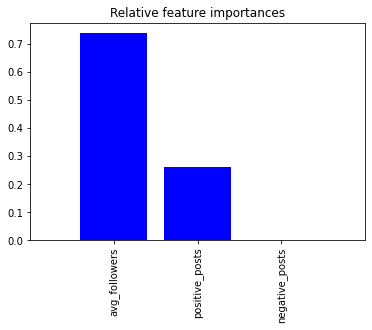

In [24]:
#Define Decision tree classifier with some default parameters
clf = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3)

#Fit the training data 
clf.fit(X_train, y_train)

pred_DT = clf.predict(X_test)
pred_DT_probs = clf.predict_proba(X_test)
print ("F1 score is: ", (f1_score(y_test,pred_DT)))
# clf.score(X_test, y_test)
print ("Accuracy is: ", (accuracy_score(y_test,pred_DT)*100).round(2))

feature_importance(clf)

## Logistic Regression

F1 score is:  0.10256410256410257
Accuracy is:  46.97


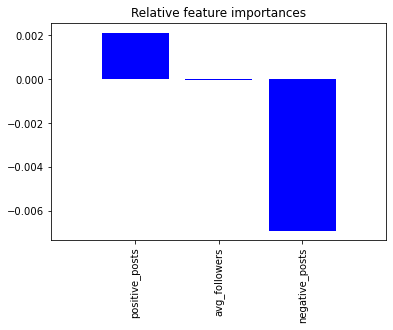

In [25]:
lr_imb = LogisticRegression(solver='lbfgs',max_iter=100000).fit(X_train, y_train)
y_pred_lr_imb = lr_imb.predict(X_test)
y_predProba_lr_imb = lr_imb.predict_proba(X_test)
print ("F1 score is: ", (f1_score(y_test,y_pred_lr_imb)))
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr_imb)*100).round(2))

importances = lr_imb.coef_[0]
indices = np.argsort(importances)[::-1]
feature_order = np.array([train.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(train.shape[1]), importances[indices],color="b",  align="center")
plt.xticks(range(train.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, train.shape[1]])
plt.show()

## XGBClassifier

/opt/anaconda3/envs/masterthesis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/masterthesis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:32:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


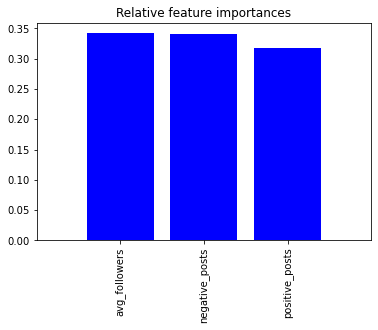

F1 score is:  0.43750000000000006
Accuracy is:  45.45


In [26]:
model = XGBClassifier().fit(X_train, y_train)

pred_XGB = model.predict(X_test)
pred_XGB_prob = model.predict_proba(X_test)
feature_importance(model)

print ("F1 score is: ", (f1_score(y_test,pred_XGB)))
print ("Accuracy is: ", (accuracy_score(y_test,pred_XGB)*100).round(2))
# model.score(X_test, y_test)

## Naive bayes

In [27]:
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

pred_nb = model_nb.predict(X_test)
pred_NB_prob = model_nb.predict_proba(X_test)

print ("F1 score is: ", (f1_score(y_test,pred_nb)))
print ("Accuracy is: ", (accuracy_score(y_test,pred_nb)*100).round(2))
# model_nb.score(X_test, y_test)

F1 score is:  0.28260869565217395
Accuracy is:  50.0


## SVC

In [28]:
# model_svc = SVC(kernel = "poly", probability=True)
# model_svc.fit(X_train, y_train)

# pred_svc = model_svc.predict(X_test)
# pred_svc_prob = model_svc.predict_proba(X_test)

# print ("F1 score is: ", (f1_score(y_test,pred_svc)))
# print ("Accuracy is: ", (accuracy_score(y_test,pred_svc)*100).round(2))
# # model_svc.score(X_test, y_test)

## Random Forest

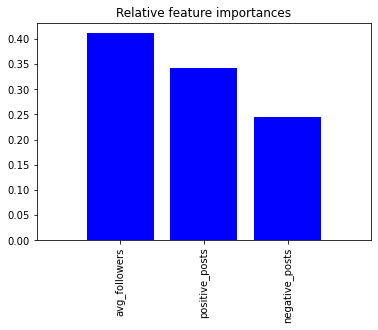

F1 score is:  0.46511627906976744
Accuracy is:  47.73


In [29]:
model_rf = RandomForestClassifier(n_estimators=50, random_state=1, n_jobs=-1).fit(X_train, y_train)

pred_rf = model_rf.predict(X_test)
pred_RF_prob = model_rf.predict_proba(X_test)
feature_importance(model_rf)

print ("F1 score is: ", (f1_score(y_test,pred_rf)))
print ("Accuracy is: ", (accuracy_score(y_test,pred_rf)*100).round(2))
# model_rf.score(X_test, y_test)

## Ensemble

In [30]:
model_voting = VotingClassifier(
    estimators=[
        ('rf', model_rf),
        ('gnb', model_nb),
        ('xgb', model),
    ],voting='soft')

pipe = make_pipeline(
    SimpleImputer(),
    model_voting
)


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_pred_prob = pipe.predict_proba(X_test)

print ("F1 score is: ", (f1_score(y_test,y_pred)))
print ("Accuracy is: ", (accuracy_score(y_test,y_pred)*100).round(2))
# pipe.score(X_test, y_test)

/opt/anaconda3/envs/masterthesis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/masterthesis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/masterthesis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:32:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score is:  0.4
Accuracy is:  43.18


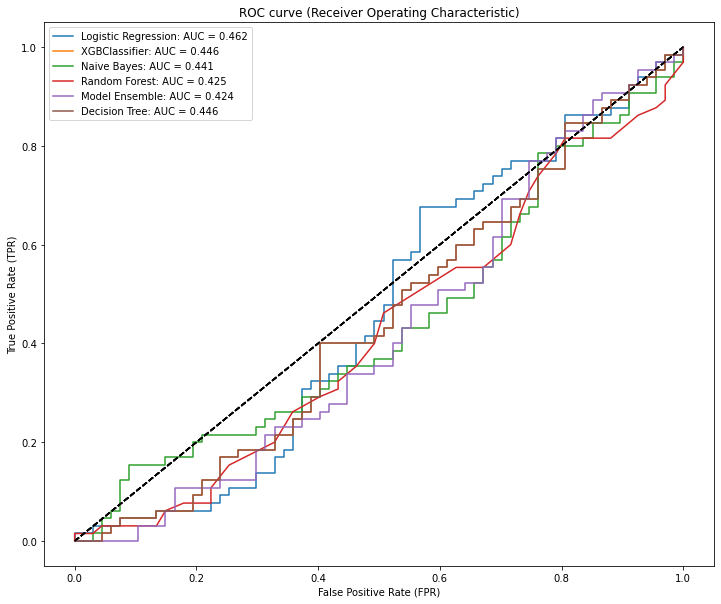

In [31]:
plt.figure(figsize=(12,10))

for test, pred, name in zip([y_test, y_test, y_test, y_test, y_test, y_test], [y_predProba_lr_imb[:,1], pred_XGB_prob[:,1], pred_NB_prob[:,1], pred_RF_prob[:,1], y_pred_prob[:,1], pred_XGB_prob[:,1]], ['Logistic Regression','XGBClassifier', 'Naive Bayes', 'Random Forest','Model Ensemble', 'Decision Tree']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

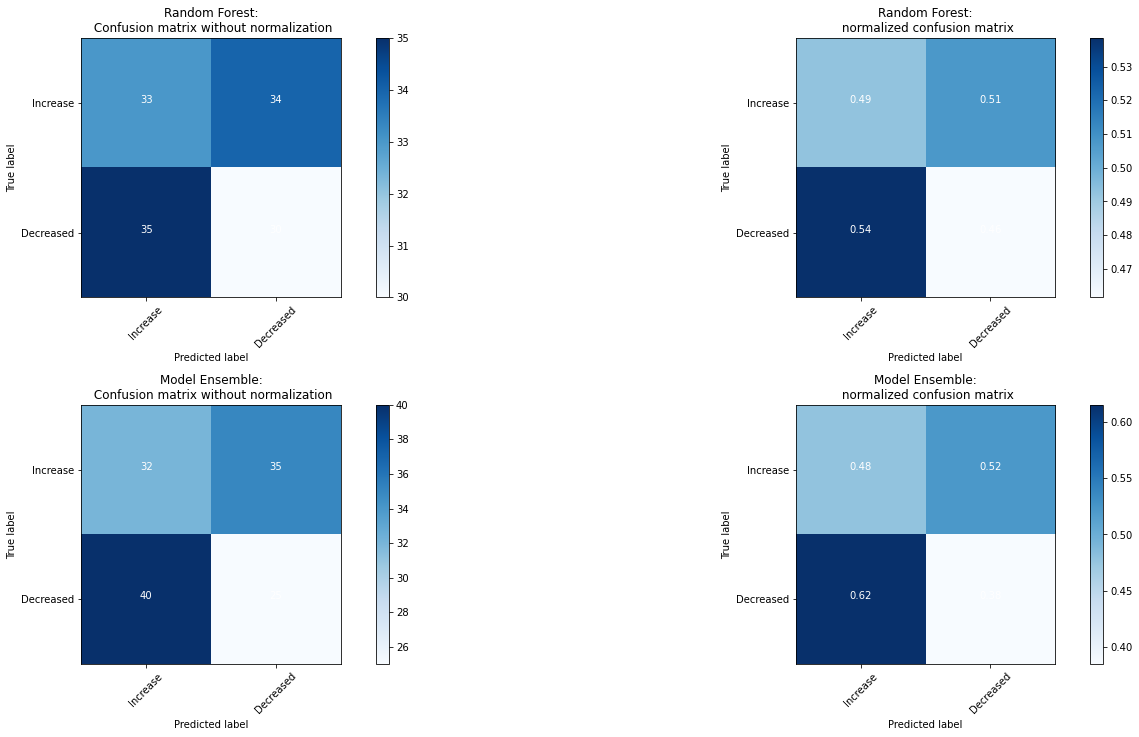

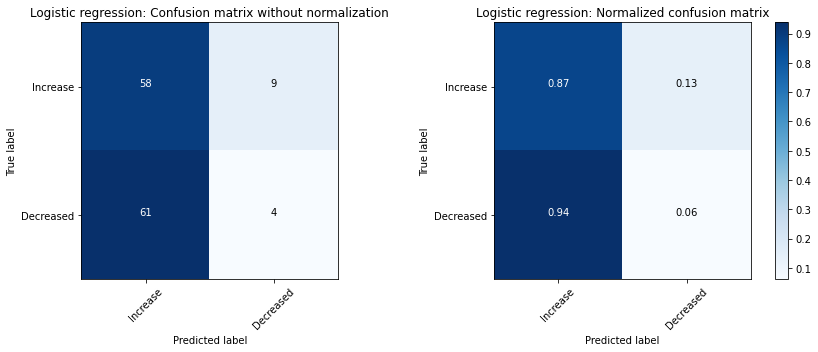

In [32]:
# Compute confusion matrix
class_names = ['Increase', 'Decreased']
cnf_matrix_clf = confusion_matrix(y_test, pred_DT)
cnf_matrix_XGB = confusion_matrix(y_test, pred_XGB) 
cnf_matrix_NB = confusion_matrix(y_test, pred_nb) 
# cnf_matrix_svm = confusion_matrix(y_test, pred_svc)
cnf_matrix_RF = confusion_matrix(y_test, pred_rf)
cnf_matrix_ensemble = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)

plt.figure(figsize=(20, 15))

#Plot Decision Tree confusion matrix
plt.subplot(321) 
plot_confusion_matrix(cnf_matrix_clf, classes=class_names,
                      title='Decision Tree:\n Confusion matrix without normalization')

#Plot Decision Tree normalized confusion matrix
plt.subplot(322) 
plot_confusion_matrix(cnf_matrix_clf, classes=class_names, normalize=True,
                      title='Decision Tree:\n normalized confusion matrix')


#Plot XGB confusion matrix
plt.subplot(323) 
plot_confusion_matrix(cnf_matrix_XGB, classes=class_names,
                      title='XGBoosting:\n Confusion matrix without normalization')

#Plot XGB normalized onfusion matrix
plt.subplot(324) 
plot_confusion_matrix(cnf_matrix_XGB, classes=class_names, normalize=True,
                      title='XGBoosting:\n normalized confusion matrix')

#Plot Naive Bayes confusion matrix
plt.subplot(325) 
plot_confusion_matrix(cnf_matrix_NB, classes=class_names,
                      title='Naive Bayes:\n Confusion matrix without normalization')

#Plot Naive Bayes normalized onfusion matrix
plt.subplot(326) 
plot_confusion_matrix(cnf_matrix_NB, classes=class_names, normalize=True,
                      title='Naive Bayes:\n normalized confusion matrix')
plt.show()

np.set_printoptions(precision=2)

plt.figure(figsize=(20, 15))

#Plot SVM confusion matrix
# plt.subplot(321) 
# plot_confusion_matrix(cnf_matrix_svm, classes=class_names,
#                       title='SVM:\n Confusion matrix without normalization')

# #Plot SVM normalized confusion matrix
# plt.subplot(322) 
# plot_confusion_matrix(cnf_matrix_svm, classes=class_names, normalize=True,
#                       title='SVM:\n normalized confusion matrix')

#Plot RF confusion matrix
plt.subplot(323) 
plot_confusion_matrix(cnf_matrix_RF, classes=class_names,
                      title='Random Forest:\n Confusion matrix without normalization')

#Plot RF normalized confusion matrix
plt.subplot(324) 
plot_confusion_matrix(cnf_matrix_RF, classes=class_names, normalize=True,
                      title='Random Forest:\n normalized confusion matrix')

#Plot Model Ensemble confusion matrix
plt.subplot(325) 
plot_confusion_matrix(cnf_matrix_ensemble, classes=class_names,
                      title='Model Ensemble:\n Confusion matrix without normalization')

#Plot Model Ensemble normalized confusion matrix
plt.subplot(326) 
plot_confusion_matrix(cnf_matrix_ensemble, classes=class_names, normalize=True,
                      title='Model Ensemble:\n normalized confusion matrix')


plt.show()

cnf_matrix = confusion_matrix(y_test, y_pred_lr_imb)

# Plot non-normalized confusion matrix
plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Logistic regression: Confusion matrix without normalization')

# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Logistic regression: Normalized confusion matrix')


plt.show()

# Rebalancing Data and testing models

In [33]:
# X_train, X_test, y_train, y_test
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
# smote = SMOTE(sampling_strategy='minority',random_state=12345)
smote = SMOTE(sampling_strategy='minority',random_state=12345)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

In [34]:
def plot_2d_space(X, y, label='Classes', title='x', xlabel='x', ylabel='y'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m, s=2
        )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')

In [35]:
from collections import Counter

print('Original label %s' % Counter(y_train))
print('SMOTE label %s' % Counter(y_sm))

fig = plt.figure(figsize=(15, 5)) #specify figure size

ax0 = plt.subplot(121)
ax0 = plot_2d_space(np.array(X_train), y_train, title='Imbalanced data', xlabel='data', ylabel='rfm_score')

ax1 = plt.subplot(122)
ax1 = plot_2d_space(np.array(X_sm), y_sm, title='Rebalanced data (SMOTE)', xlabel='data', ylabel='rfm_score')

Original label Counter({0: 162, 1: 146})
SMOTE label Counter({1: 162, 0: 162})


In [36]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = target.value_counts() / len(target)
smote_dist = pd.Series(y_sm).value_counts() / len(pd.Series(y_sm))

fig, ax = plt.subplots()

ax.barh(['X_train (SMOTE)','Test','Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['X_train (SMOTE)','Test','Train','Data'], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]], left=[smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['X_train (SMOTE)', 'Test', 'Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

# Decision Tree Balanced

F1 score is:  0.4444444444444445
Accuracy is:  54.55


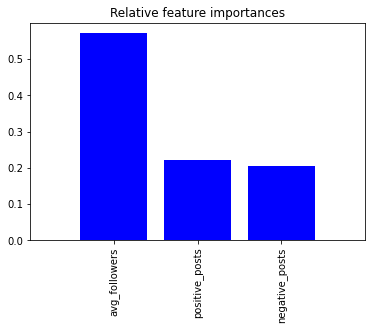

In [37]:
#Define Decision tree classifier with some default parameters
clf_bal = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3).fit(X_sm, y_sm)

pred_DT_bal = clf_bal.predict(X_test)
pred_DT_probs_bal = clf.predict_proba(X_test)
print ("F1 score is: ", (f1_score(y_test,pred_DT_bal)))
# clf.score(X_test, y_test)
print ("Accuracy is: ", (accuracy_score(y_test,pred_DT_bal)*100).round(2))

feature_importance(clf_bal)

# Logistic Regression Balanced

F1 score is:  0.5314685314685315
Accuracy is:  49.24


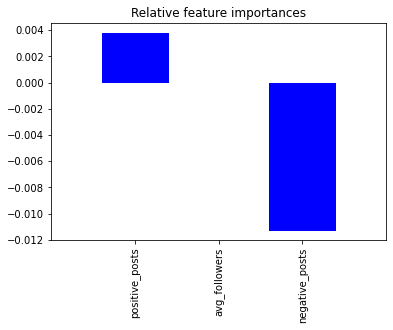

In [38]:
lr_bal = LogisticRegression(solver='lbfgs').fit(X_sm, y_sm)

y_pred_lr_bal = lr_bal.predict(X_test)
y_predProba_lr_bal = lr_bal.predict_proba(X_test)

print ("F1 score is: ", (f1_score(y_test,y_pred_lr_bal)))
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr_bal)*100).round(2))

importances = lr_bal.coef_[0]
indices = np.argsort(importances)[::-1]
feature_order = np.array([train.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(train.shape[1]), importances[indices],color="b",  align="center")
plt.xticks(range(train.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, train.shape[1]])
plt.show()

# XGBBoost Balanced

[17:32:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/masterthesis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/masterthesis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


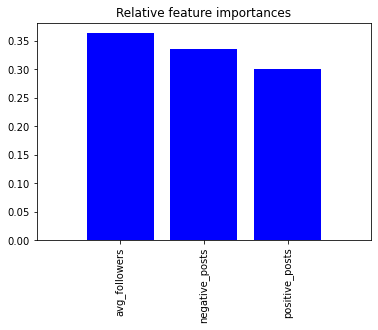

F1 score is:  0.45801526717557256
Accuracy is:  46.21


In [39]:
model_bal = XGBClassifier().fit(X_sm, y_sm)

pred_XGB_bal = model_bal.predict(X_test)
pred_XGB_prob_bal = model_bal.predict_proba(X_test)
feature_importance(model_bal)

print ("F1 score is: ", (f1_score(y_test,pred_XGB_bal)))
print ("Accuracy is: ", (accuracy_score(y_test,pred_XGB_bal)*100).round(2))
# model.score(X_test, y_test)

# Naive bayes balanced

In [40]:
model_nb_bal = GaussianNB().fit(X_sm, y_sm)

pred_nb_bal = model_nb_bal.predict(X_test)
pred_NB_prob_bal = model_nb.predict_proba(X_test)

print ("F1 score is: ", (f1_score(y_test,pred_nb_bal)))
print ("Accuracy is: ", (accuracy_score(y_test,pred_nb_bal)*100).round(2))
# model_nb.score(X_test, y_test)

F1 score is:  0.3559322033898305
Accuracy is:  42.42


# SVC balanced

In [41]:
# model_svc_bal = SVC(kernel = "poly", probability=True).fit(X_sm, y_sm)

# pred_svc_bal = model_svc_bal.predict(X_test)
# pred_svc_prob_bal = model_svc_bal.predict_proba(X_test)

# print ("F1 score is: ", (f1_score(y_test,pred_svc_bal)))
# print ("Accuracy is: ", (accuracy_score(y_test,pred_svc_bal)*100).round(2))
# model_svc.score(X_test, y_test)

# Random Forest Balance

In [42]:
model_rf_bal = RandomForestClassifier(n_estimators=50, random_state=1, n_jobs=-1).fit(X_sm, y_sm)

pred_rf_bal = model_rf_bal.predict(X_test)
pred_RF_prob_bal = model_rf_bal.predict_proba(X_test)
feature_importance(model_rf_bal)

print ("F1 score is: ", (f1_score(y_test,pred_rf_bal)))
print ("Accuracy is: ", (accuracy_score(y_test,pred_rf_bal)*100).round(2))
# model_rf.score(X_test, y_test)

F1 score is:  0.47058823529411764
Accuracy is:  45.45


# Ensemble Balanced

In [43]:
model_voting_bal = VotingClassifier(
    estimators=[
        ('rf', model_rf_bal),
#         ('svc', model_svc_bal),
        ('gnb', model_nb_bal),
        ('xgb', model_bal),
    ],voting='soft')

pipe_bal = make_pipeline(
    SimpleImputer(),
    model_voting
)


pipe_bal.fit(X_sm, y_sm)
y_pred_bal = pipe_bal.predict(X_test)
y_pred_prob_bal = pipe_bal.predict_proba(X_test)

print ("F1 score is: ", (f1_score(y_test,y_pred_bal)))
print ("Accuracy is: ", (accuracy_score(y_test,y_pred_bal)*100).round(2))
# pipe.score(X_test, y_test)

[17:32:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score is:  0.46616541353383456
Accuracy is:  46.21


/opt/anaconda3/envs/masterthesis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/masterthesis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/opt/anaconda3/envs/masterthesis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


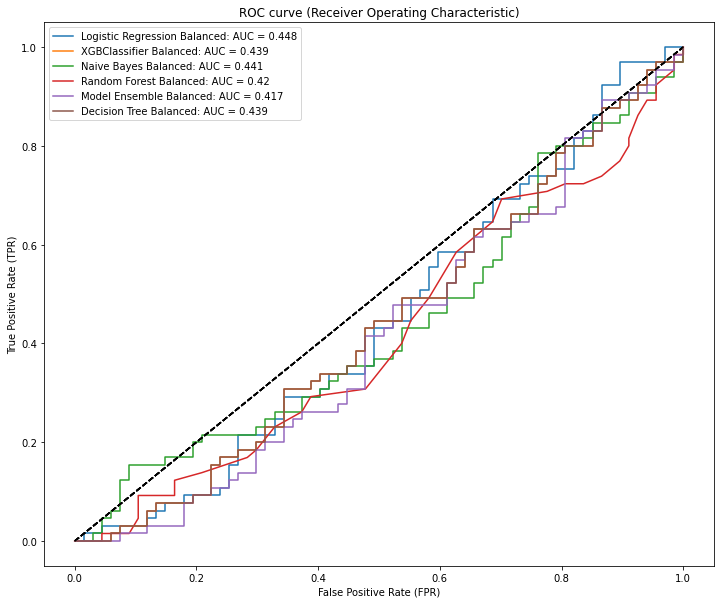

In [44]:
plt.figure(figsize=(12,10))

for test, pred, name in zip([y_test, y_test, y_test, y_test, y_test, y_test], [y_predProba_lr_bal[:,1], pred_XGB_prob_bal[:,1], pred_NB_prob_bal[:,1], pred_RF_prob_bal[:,1], y_pred_prob_bal[:,1], pred_XGB_prob_bal[:,1]], ['Logistic Regression Balanced','XGBClassifier Balanced', 'Naive Bayes Balanced', 'Random Forest Balanced','Model Ensemble Balanced', 'Decision Tree Balanced']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()